In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from evaluation import evaluate_search_system 
from preprocess import semantic_search_expanded_query
from semantic_search import semantic_search ,enhanced_search, generate_embeddings, build_faiss_index, enhanced_search_with_faiss
from utils import convert_embedding_string_to_array, display_search_results

I recommend not to run the full notebook, as some experiments (ReRank and FAISS) can take up to 35 mins to run each. For further explanation of the methodology you can visit: https://www.overleaf.com/read/dbdnkdksnrvx#2a3038

### Data loading 

In [2]:
items = pd.read_csv("../data/5k_items_processed.csv")
queries = pd.read_csv("../data/queries.csv")

test_queries = pd.read_csv("../data/test_queries.csv")
test_queries=list(test_queries['query'])



In [5]:
items.head(4)

,_id,itemId,itemMetadata,itemProfile,merchantId,jointText,jointTextNatural,organic,lacFree,vegan,avgBasketPrice,total_orders,category_name,reorderRate,embeddings_jointText,embeddings_jointTextNatural
0,6813b2b5b7476b2ec454b7ff,442731c2-144b-4c5c-b81e-e0cf9dfa9630,"{""category_name"":""Alimentos Básicos"",""descript...","{""metrics"":{""avgBasketPrice"":159.89,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Macarrão Pena com Ovos Adria 500g Pacote 500g ...,Macarrão Pena com Ovos Adria 500g pertencente ...,False,False,False,159.89,16,Alimentos Básicos,0.0,"[-0.04738183692097664, 0.047670163214206696, -...","[-0.0449894517660141, 0.05385494977235794, -0...."
1,6813b2b5b7476b2ec454b800,4a6d4a8f-c1bf-4457-a448-4a3b5e1eb20c,"{""category_name"":""Doces e Sobremesas"",""descrip...","{""metrics"":{""avgBasketPrice"":182.44,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Goplana Squares Pistache 200g Embalagem 200g D...,Goplana Squares Pistache 200g pertencente à ca...,False,False,False,182.44,1,Doces e Sobremesas,0.0,"[-0.042557526379823685, 0.014497015625238419, ...","[-0.03434642776846886, 0.03349967673420906, -0..."
2,6813b2b5b7476b2ec454b801,5380e263-c202-45cf-8eae-81e54573f122,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":190.63,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Creme para Pentear Boom Definição Intensa Seda...,Creme para Pentear Boom Definição Intensa Seda...,False,False,False,190.63,3,Higiene e Cuidados Pessoais,0.0,"[-0.04810170456767082, 0.06214147433638573, -0...","[-0.03327842429280281, 0.06287676841020584, -0..."
3,6813b2b5b7476b2ec454b802,595ce305-ddf5-49fc-9a8c-b50a9ccf6267,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":113.56,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Desodorante Invisible For Black & White Aeroso...,Desodorante Invisible For Black & White Aeroso...,False,False,False,113.56,3,Higiene e Cuidados Pessoais,0.0,"[-0.052515942603349686, 0.04236625134944916, 0...","[-0.042794786393642426, 0.0454389750957489, -0..."


## Model Evaluations

### Baselines

In [3]:
item_embeddings=items['embeddings_jointText']
item_embeddings_natural=items['embeddings_jointTextNatural']

In [4]:

item_embeddings = np.array([convert_embedding_string_to_array(emb) for emb in items['embeddings_jointText']])
item_embeddings_natural = np.array([convert_embedding_string_to_array(emb) for emb in items['embeddings_jointTextNatural']])

#### Joint Text

In [7]:
results=[]
#item_embeddings = np.array(embeddings_items_natural) 
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search(query_embedding, item_embeddings, top_k=10)
    results.append(top_indices.tolist())

In [13]:
import json
# Evaluate the search system
metrics = evaluate_search_system(test_queries, results)

# Print the evaluation results
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Save results to a JSON file
filename = "../results/baseline_jointText" + ".json"
with open(filename, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"\nResults saved to {filename}")
print("\nMetrics dictionary:")


Evaluation Results:
mrr: 0.627
average_rank: 3.685
hit_rate@1: 0.535
precision@1: 0.535
recall@1: 0.535
hit_rate@3: 0.670
precision@3: 0.223
recall@3: 0.670
hit_rate@5: 0.725
precision@5: 0.145
recall@5: 0.725
hit_rate@10: 0.830
precision@10: 0.083
recall@10: 0.830

Results saved to ../results/baseline_jointText.json

Metrics dictionary:


Time measurement

In [20]:
import time

# Start time
start_time = time.time()

# Your code
query = "Arroz integral para alimentação saudável"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
items_df = items  # Assuming items is defined somewhere
top_k_indices, similarities = semantic_search(query_embedding, item_embeddings, top_k=10)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.3513 seconds


#### Joint Text Natural

In [21]:
results_natural=[]
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search(query_embedding, item_embeddings_natural, top_k=10)
    results_natural.append(top_indices.tolist())

In [ ]:

metrics_natural = evaluate_search_system(test_queries, results_natural)

# Print the evaluation results
print("Evaluation Results:")
for metric, value in metrics_natural.items():
    print(f"{metric}: {value:.3f}")

# Save results to a JSON file
filename = "../results/baseline_jointTextNatural" + ".json"
with open(filename, 'w') as f:
    json.dump(metrics_natural, f, indent=4)

print(f"\nResults saved to {filename}")
print("\nMetrics dictionary:")


Evaluation Results:
mrr: 0.604
average_rank: 3.705
hit_rate@1: 0.500
precision@1: 0.500
recall@1: 0.500
hit_rate@3: 0.655
precision@3: 0.218
recall@3: 0.655
hit_rate@5: 0.740
precision@5: 0.148
recall@5: 0.740
hit_rate@10: 0.835
precision@10: 0.083
recall@10: 0.835

Results saved to ../results/baseline_jointTextNatural.json

Metrics dictionary:


In [28]:
import time

# Start time
start_time = time.time()

# Your code
query = "Arroz integral para alimentação saudável"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
items_df = items  # Assuming items is defined somewhere
top_k_indices, similarities = semantic_search(query_embedding, item_embeddings_natural, top_k=10)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.3893 seconds


### Display

Search Query: 'Prato de mezze mediterrâneo'
Top 10 Results:
--------------------------------------------------------------------------------
Rank 1: Prato de berinjela frita
  Description: Prato de berinjela frita com mistura egípcia, servido com 4 pedaços de pão sírio e o molho secreto egípcio.
  Price: R$24.99
  Category: Pães
  Similarity Score: 0.5866
  Image URL: https://static.ifood-static.com.br/image/upload/t_low/pratos/a99dcb42-75ac-4f70-b10e-88d278ec452f/202502090144_8U6X_i.jpg
--------------------------------------------------------------------------------
Rank 2: Falafel egípcio com mistura egípcia
  Description: 4 pedaços de prato de falafel egípcio com 6 pedaços de pão sírio com picles egípcios com mistura egípcia
  Price: R$25.99
  Category: Pães
  Similarity Score: 0.5612
  Image URL: https://static.ifood-static.com.br/image/upload/t_low/pratos/a99dcb42-75ac-4f70-b10e-88d278ec452f/202502152156_7P12_i.jpg
------------------------------------------------------------------

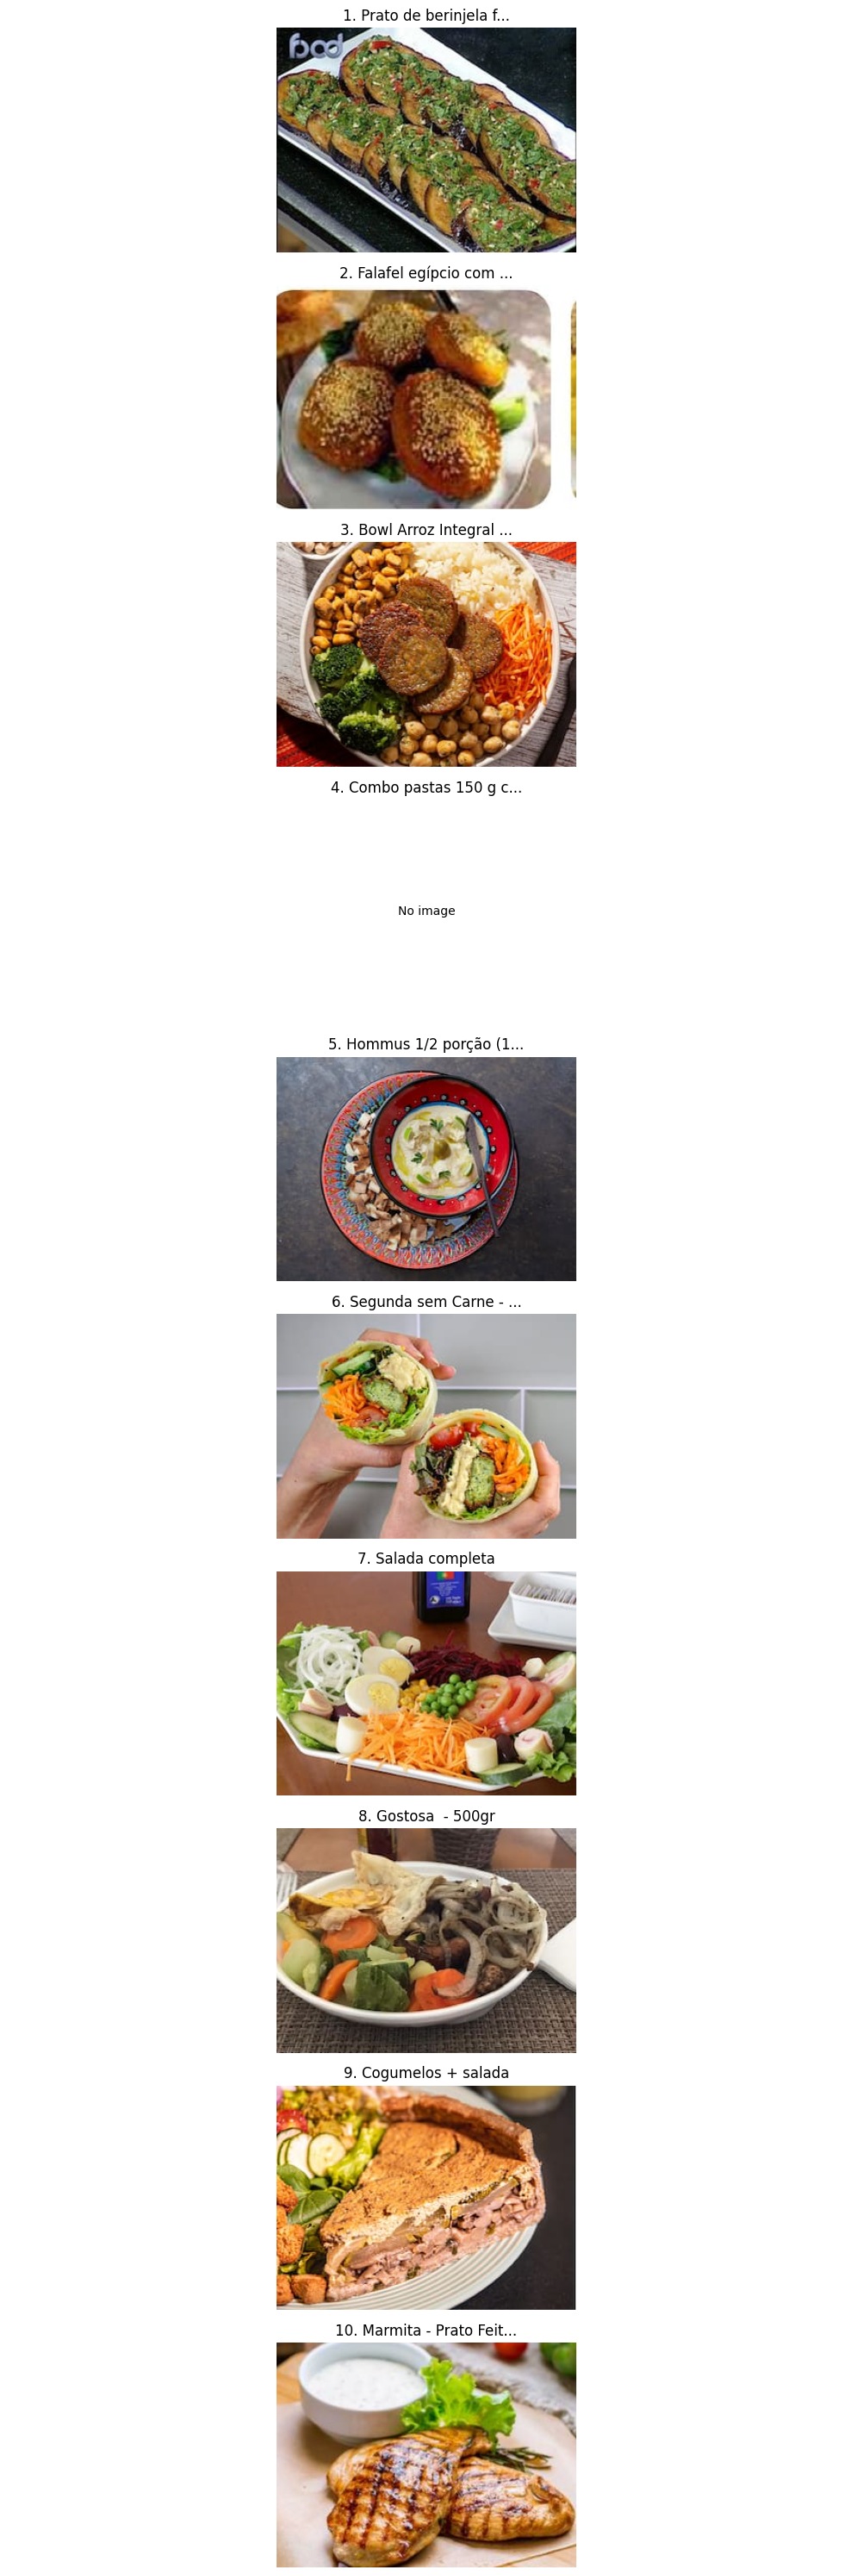

In [6]:
query = "Prato de mezze mediterrâneo"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
#item_embeddings = np.array(items['embeddings_jointText'])  # Assuming embeddings are stored in the DataFrame
items_df = items

# Display search results with images
top_indices, top_scores = display_search_results(query, query_embedding, item_embeddings, items_df, top_k=10)


### Re-Rank

In [ ]:
results_rr=[]
for query in tqdm(test_queries, desc="Processing queries", unit="query"):
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query, item_embeddings, items_df=items, top_k=10)
    results_rr.append(top_indices)

Processing queries: 100%|██████████| 200/200 [36:21<00:00, 10.91s/query]


In [ ]:
metrics_rr = evaluate_search_system(test_queries, results_rr)
print("Evaluation Results:")
for metric, value in metrics_rr.items():
    print(f"{metric}: {value:.3f}")

# Save results to a JSON file
filename = "../results/rerank_jointText" + ".json"
with open(filename, 'w') as f:
    json.dump(metrics_rr, f, indent=4)

print(f"\nResults saved to {filename}")
print("\nMetrics dictionary:")

Evaluation Results:
mrr: 0.581
average_rank: 3.680
hit_rate@1: 0.440
precision@1: 0.440
recall@1: 0.440
hit_rate@3: 0.675
precision@3: 0.225
recall@3: 0.675
hit_rate@5: 0.760
precision@5: 0.152
recall@5: 0.760
hit_rate@10: 0.840
precision@10: 0.084
recall@10: 0.840


##### Time measurement

In [39]:
import time


start_time = time.time()


query = "Arroz integral para alimentação saudável"

top_indices = enhanced_search(query ,item_embeddings_natural, items_df=items, top_k=10)


end_time = time.time()

# elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 7.7811 seconds


### Items query expansion

In [40]:
query_gallery_embedding=generate_embeddings(queries['search_term_pt'])

In [47]:
embeddings_items_query=items['embeddings_similar_queries_expanded']
embeddings_items_query = np.array([convert_embedding_string_to_array(emb) for emb in embeddings_items_query])

In [ ]:
results_q_e=[]
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search(query_embedding, embeddings_items_query, top_k=10)
    results_q_e.append(top_indices.tolist())

In [ ]:
metrics_q_e = evaluate_search_system(test_queries, results_q_e)
print("Evaluation Results:")
for metric, value in metrics_q_e.items():
    print(f"{metric}: {value:.3f}")

# Save results to a JSON file
filename = "../results/query_expansion" + ".json"
with open(filename, 'w') as f:
    json.dump(metrics_q_e, f, indent=4)

print(f"\nResults saved to {filename}")


Evaluation Results:
mrr: 0.604
average_rank: 3.725
hit_rate@1: 0.500
precision@1: 0.500
recall@1: 0.500
hit_rate@3: 0.690
precision@3: 0.230
recall@3: 0.690
hit_rate@5: 0.750
precision@5: 0.150
recall@5: 0.750
hit_rate@10: 0.835
precision@10: 0.083
recall@10: 0.835

Results saved to ../results/query_expansion.json

Metrics dictionary:


In [55]:
import time


start_time = time.time()


query = "Arroz integral para alimentação saudável"

query_embedding = generate_embeddings([query])[0] 
top_indices, top_scores = semantic_search(query_embedding, embeddings_items_query, top_k=10)


end_time = time.time()

# elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.5448 seconds


In [144]:
results=[]
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search_expanded_query(query_embedding, embeddings_items_query, query_gallery_embedding, top_k=100)
    results.append(top_indices.tolist())
    

### FAISS

In [63]:
# Assuming item_embeddings is your list/array of embeddings
faiss_index = build_faiss_index(item_embeddings)

In [79]:
# Start time
start_time = time.time()

# Your code
query = "Arroz integral para alimentação saudável"

results = enhanced_search_with_faiss(query, faiss_index, items_df)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 13.9625 seconds


In [65]:
results_faiss=[]
for query in test_queries:
    top_indices = enhanced_search_with_faiss(query, faiss_index, items_df)
    results_faiss.append(top_indices)

In [76]:
metrics_faiss = evaluate_search_system(test_queries, results_faiss)
print("Evaluation Results:")
for metric, value in metrics_faiss.items():
    print(f"{metric}: {value:.3f}")

# Save results to a JSON file
filename = "../results/faiss" + ".json"
with open(filename, 'w') as f:
    json.dump(metrics_faiss, f, indent=4)

print(f"\nResults saved to {filename}")

Evaluation Results:
mrr: 0.605
average_rank: 3.475
hit_rate@1: 0.480
precision@1: 0.480
recall@1: 0.480
hit_rate@3: 0.700
precision@3: 0.233
recall@3: 0.700
hit_rate@5: 0.790
precision@5: 0.158
recall@5: 0.790
hit_rate@10: 0.845
precision@10: 0.084
recall@10: 0.845

Results saved to ../results/faiss.json


### Query Expansion

In [ ]:
results_q=[]
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search_expanded_query(query_embedding, embeddings_items_query, query_gallery_embedding, top_k=100)
    results_q.append(top_indices.tolist())
    

In [ ]:
metrics_q = evaluate_search_system(test_queries, results_q)
print("Evaluation Results:")
for metric, value in metrics_q.items():
    print(f"{metric}: {value:.3f}")